In [1]:
from os.path import join as pathjoin
import sys
sys.path.insert(0, '/home/mlepekhin/Non-thematic-Text-Classification/code/allennlp_experiments')

from data_processing import *
from interpretation import *
from models import *
from training import *

In [2]:
DATA_DIR = '/home/mlepekhin/data'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_xlm_roberta_enru_clean_1' 
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'xlm-roberta-base'
MAX_TOKENS = 512

### Loading of the pretrained model

In [4]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))
model = build_pool_transformer_model(vocab, transformer_model)

01262021 21:17:17|INFO|allennlp.data.vocabulary| Loading token dictionary from /home/mlepekhin/models/allennlp_xlm_roberta_enru_clean_1/vocab.
01262021 21:17:17|INFO|filelock| Lock 140523551480512 acquired on /home/mlepekhin/models/allennlp_xlm_roberta_enru_clean_1/vocab/.lock
01262021 21:17:17|INFO|filelock| Lock 140523551480512 released on /home/mlepekhin/models/allennlp_xlm_roberta_enru_clean_1/vocab/.lock


Building the model


01262021 21:17:18|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /home/mlepekhin/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
01262021 21:17:18|INFO|transformers.configuration_utils| Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

01262021 21:17:18|INFO|transformers.modeling_util

In [5]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A8', 1: 'A1', 2: 'A12', 3: 'A14', 4: 'A11', 5: 'A16', 6: 'A7', 7: 'A17', 8: 'A4', 9: 'A9', 10: 'A22'}
dict_values(['A8', 'A1', 'A12', 'A14', 'A11', 'A16', 'A7', 'A17', 'A4', 'A9', 'A22'])


In [6]:
if torch.cuda.is_available():
    cuda_device = 0
else:
    cuda_device = -1
print(cuda_device)
model.load_state_dict(torch.load(BEST_MODEL, map_location=f'cuda:{cuda_device}'))

0


<All keys matched successfully>

### Data loading

In [7]:
en_test_df = pd.read_csv('/home/mlepekhin/ru-gpts/en_generated_texts/en_small_all_50.csv')
en_test_df.head()

,Unnamed: 0,Unnamed: 0.1,prefix,target,text,topic
0,0,0,the original sabre canopy was released onto th...,A1,the original sabre canopy was released onto th...,arhitecture
1,1,1,car parking there are supervised car parks for...,A1,car parking there are supervised car parks for...,arhitecture
2,2,2,car parking there are supervised car parks for...,A1,car parking there are supervised car parks for...,arhitecture
3,3,3,the original sabre canopy was released onto th...,A1,the original sabre canopy was released onto th...,arhitecture
4,4,4,the original sabre canopy was released onto th...,A1,the original sabre canopy was released onto th...,arhitecture


In [8]:
true_classes = en_test_df.target.values
sentences = en_test_df.text.values

### Preliminary analysis

In [9]:
dataset_reader = build_transformer_dataset_reader(transformer_model, MAX_TOKENS)
predictor = TextClassifierPredictor(model, dataset_reader=dataset_reader)
predicted_classes = np.array(predict_classes(sentences, predictor, vocab))

01262021 21:17:57|INFO|transformers.configuration_utils| loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlm-roberta-base-config.json from cache at /home/mlepekhin/.cache/torch/transformers/762ddd751172e9d3229e5da17a459eee6c0dfdc237c718944d0b1a85f06c7e1e.2b0f807393c56e8861a31cd67d2fc0b45d71d9735dd47dd66afb650f90b6d2a8
01262021 21:17:57|INFO|transformers.configuration_utils| Model config XLMRobertaConfig {
  "architectures": [
    "XLMRobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 250002
}

01262021 21:17:58|INFO|transformers.tokenization_

In [10]:
print(type(predicted_classes == 'A1'))

<class 'numpy.ndarray'>


In [11]:
print(len(np.unique(true_classes)))

10


In [12]:
calc_classifier_metrics(predicted_classes, true_classes)

label (argum) f1_score 0.32298136645962733 precision 0.23423423423423423 recall 0.52
label (fictive) f1_score 0.40944881889763773 precision 0.9629629629629629 recall 0.26
label (instruct) f1_score 0.47107438016528924 precision 0.4014084507042254 recall 0.57
label (reporting) f1_score 0.3459459459459459 precision 0.3764705882352941 recall 0.32
label (legal) f1_score 0.535031847133758 precision 0.7368421052631579 recall 0.42
label (personal) f1_score 0.15748031496062992 precision 0.37037037037037035 recall 0.1
label (commercial) f1_score 0.3612903225806452 precision 0.26666666666666666 recall 0.56
label (research) f1_score 0.12612612612612614 precision 0.6363636363636364 recall 0.07
label (info) f1_score 0.3508771929824562 precision 0.2702702702702703 recall 0.5
label (eval) f1_score 0.2222222222222222 precision 0.5384615384615384 recall 0.14
accuracy 0.346


01272021 00:39:40|INFO|numexpr.utils| Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
01272021 00:39:40|INFO|numexpr.utils| NumExpr defaulting to 8 threads.


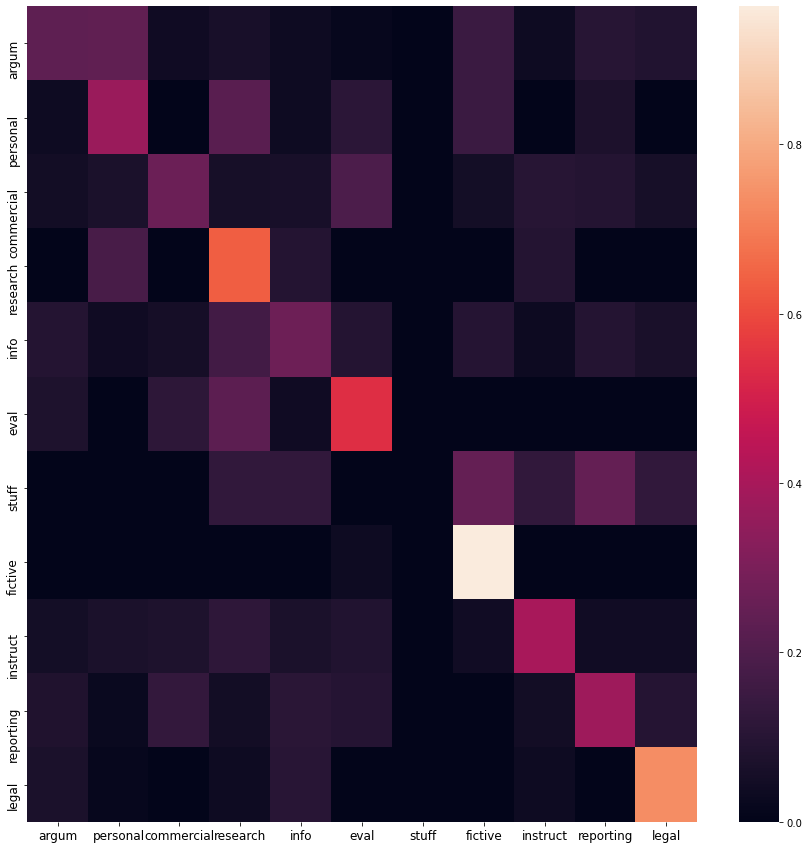

In [13]:
plot_confusion_matrix(predicted_classes, true_classes)

### Saliency Gradient Interpretation

In [14]:
#smooth_grad = SmoothGradient(predictor)
simple_grad = SimpleGradient(predictor)
#integrated_grad = IntegratedGradient(predictor)

In [15]:
mistake_ids = []

for sent_id in range(len(true_classes)):
    if true_classes[sent_id] != predicted_classes[sent_id]:
        mistake_ids.append(sent_id)

In [16]:
interpret_sentence(
    sentences[mistake_ids[0]], dataset_reader.tokenizer, 50, 
    [simple_grad],
    label_description[true_classes[mistake_ids[0]]],
    label_description[predicted_classes[mistake_ids[0]]]
)

TRUE LABEL: eval
LABEL: commercial
<class 'allennlp.interpret.saliency_interpreters.simple_gradient.SimpleGradient'> TEXT:
▁Kawasaki ▁D - Tra cker ▁С ▁недавн их ▁пор ▁Kawasaki ▁d - track er ▁125 ▁официально ▁доступ ен ▁на ▁европейско м ▁рынке ▁ . ▁Это ▁супер мо то - верс ия ▁мал енько го ▁ эн - ду ро ▁K LX ▁125 ▁ . ▁Конечно ▁же ▁ , ▁в ▁Япон ии ▁все ▁не ▁так ▁ , ▁как ▁в ▁Европе ▁ . ▁В ▁категории ▁мало ку ба тур ного ▁Dual ▁Pur pose ▁выпуска ются ▁обе ▁выше указанные ▁125 ▁- ки ▁ , ▁энд уро ▁Stock man ▁250 ▁и ▁хорошо ▁из вест ная ▁многим ▁рай дер ам ▁Super ▁Sher pa ▁ , ▁а ▁также ▁две ▁250 ▁- ки ▁- ▁энд уро ▁K LX ▁250 ▁S ▁и ▁супер мо то ▁K LX ▁250 ▁SF ▁ . ▁После дний ▁- ▁тот ▁самый ▁D - Tra cker ▁ . ▁Kawasaki ▁D - Tra cker ▁X ▁ , ▁который ▁сейчас ▁про дается ▁в ▁Япон ии ▁ , ▁и ▁D - Tra cker ▁' ▁0 ▁0 ▁немного ▁отличаются ▁ . ▁Новый ▁мо тар д ▁получил ▁инж е ктор ▁ , ▁у лучше нные ▁тормоз а ▁ , ▁чуть ▁больш ий ▁бак ▁ . ▁Пре ж ними ▁остались ▁на ▁месте ▁мал ый ▁вес ▁ , ▁ длин но ход ные ▁под

In [17]:
interpret_sentence(
    sentences[mistake_ids[1]], dataset_reader.tokenizer, 50, 
    [simple_grad],
    label_description[true_classes[mistake_ids[1]]],
    label_description[predicted_classes[mistake_ids[1]]]
)

TRUE LABEL: personal
LABEL: eval
<class 'allennlp.interpret.saliency_interpreters.simple_gradient.SimpleGradient'> TEXT:
▁Тест - дра й в ▁La da ▁Grant a ▁: ▁новая ▁надежда ▁авто град а ▁Факт ически ▁ , ▁новая ▁La da ▁Grant a ▁- ▁это ▁стара я ▁La da ▁Kali na ▁плюс ▁400 ▁новых ▁деталей ▁ . ▁Но ▁назвать ▁Гран ту ▁всего ▁лишь ▁ре стай линг ом ▁Калин ы ▁язык ▁не ▁повер н ется ▁ . ▁Авто мобиль ▁действительно ▁измени лся ▁и ▁на ▁самом ▁деле ▁стал ▁лучше ▁пре ж них ▁продуктов ▁Авто ВА За ▁ . ▁Но ▁почива ть ▁на ▁лав рах ▁то ль ят тин цам ▁еще ▁рано ▁ . ▁Kole sa ▁ . ▁R ▁u ▁выяснил и ▁ , ▁почему ▁ . ▁С юр приз ы ▁по джи дали ▁еще ▁до ▁проб ной ▁поездки ▁на ▁La da ▁Grant a ▁ . ▁Про води в ▁меня ▁к ▁машине ▁ , ▁сотрудник ▁авто сал она ▁объяснил ▁мне ▁как ▁пользоваться ▁бре л ком ▁дополнительно й ▁сигнал изации ▁: ▁" ▁Если ▁на жать ▁на ▁эту ▁кнопку ▁и ▁немного ▁по держать ▁ , ▁двигател ь ▁за вед ется ▁! ▁" ▁На жим ает ▁ . ▁Держ ит ▁ . ▁Не ▁за водится ▁ . ▁" ▁Наверное ▁это ▁из - за ▁вашего ▁коллеги ▁

In [18]:
interpret_sentence(
    sentences[mistake_ids[2]], dataset_reader.tokenizer, 50, 
    [simple_grad],
    label_description[true_classes[mistake_ids[2]]],
    label_description[predicted_classes[mistake_ids[2]]]
)

TRUE LABEL: reporting
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.simple_gradient.SimpleGradient'> TEXT:
▁среда ▁ , ▁2 ▁декабря ▁2009 ▁года ▁ , ▁12. 33 ▁Бу мага ▁всё ▁терп ит ▁Дес ять ▁бы вших ▁союз ных ▁республик ▁пере писали ▁учебник и ▁истории ▁в ▁свою ▁пользу ▁ . ▁Специалист ы ▁Национально й ▁лаборатор ии ▁внешне й ▁политики ▁провели ▁и стори ограф ический ▁анализ ▁187 ▁школьн ых ▁учебник ов ▁12 ▁государств ▁из ▁бы вшего ▁СССР ▁ . ▁ Эксперт ы ▁пришли ▁к ▁выводу ▁ , ▁что ▁на ▁страница х ▁посо бий ▁и ▁книг ▁наши ▁сосед и ▁не ▁только ▁не ▁проч ь ▁воз вели чить ▁свои ▁заслуг и ▁в ▁война х ▁и ▁про чих ▁за вое вания х ▁ , ▁но ▁и ▁на ▁пусто м ▁месте ▁критик уют ▁русских ▁ . ▁Об ъ е ктив ная ▁оценка ▁истории ▁сохран илась ▁только ▁в ▁учебник ах ▁Ар мен ии ▁и ▁Белорус сии ▁ . ▁Други ми ▁словами ▁ , ▁власти ▁10 ▁стран ▁ближ не го ▁за ру беж ья ▁со ▁школьн ой ▁с кам ь и ▁учат ▁детей ▁тому ▁ , ▁что ▁Россия ▁для ▁них ▁опас ный ▁сосед ▁ , ▁а ▁культур ную ▁мисс ию ▁своего ▁народ

In [19]:
words = dict()

In [20]:
for label in id_to_label.values():
    print(label_description[label])
    print('=' * 100)
    cur_dataset = get_dataset_by_confusion_pair(
        sentences, label, label, true_classes, predicted_classes
    )
    words[label] = get_most_frequent_trigger_words(cur_dataset, dataset_reader.tokenizer, 50, simple_grad)
    print(words[label][:100])

reporting
[('▁', 575), ('.', 198), ('▁"', 122), (',', 107), ('▁заявил', 79), ('</s>', 68), ('<s>', 46), ('▁:', 31), ('▁президент', 26), ('▁что', 24), ('▁сообщил', 24), ('▁словам', 21), ('▁»', 20), ('▁в', 20), ('▁«', 18), ('▁этом', 16), ('▁и', 16), ('>', 16), ('▁сказал', 16), ('▁США', 16), ('▁России', 15), ('</', 14), ('▁РФ', 14), ('▁сообщает', 13), ('▁)', 13), ('▁президента', 13), ('▁Президент', 13), ('▁Россия', 12), ('▁...', 12), ('▁не', 11), ('ga', 11), ('▁Новости', 11), ('▁Медведев', 11), ('▁В', 10), ('▁было', 10), ('▁на', 10), ('▁(', 10), ('▁будет', 10), ('▁апреля', 9), ('▁пресс', 9), ('я', 9), ('▁Дмитрий', 9), ('▁Напомним', 9), ('▁года', 8), ('конференц', 8), ('▁Москвы', 8), ('▁Украины', 8), ('▁власти', 8), ('▁отметил', 8), ('▁--', 8), ('▁Как', 7), ('▁сегодня', 7), ('ов', 7), ('▁2009', 7), ('▁нефти', 7), ('▁Рус', 7), ('нефть', 7), ('▁его', 7), ('▁Турци', 7), ('е', 7), ('▁будут', 7), ('▁ходе', 7), ('▁2012', 7), ('▁Тимошенко', 7), ('▁Афганистан', 7), ('▁проблемы', 7), ('▁2011', 6), 

[('▁', 87), ('.', 31), ('<s>', 8), ('▁гаджет', 7), (',', 7), ('</s>', 7), ('▁!', 6), ('▁мы', 5), ('▁можно', 5), ('▁нажмите', 4), ('▁што', 4), ('▁)', 4), ('▁фотографии', 4), ('▁(', 4), ('▁обсужден', 4), ('▁•', 3), ('▁работе', 3), ('▁PSD', 3), ('▁картинки', 3), ('▁фото', 3), ('▁вашем', 3), ('▁можете', 3), ('▁:', 3), ('▁нужно', 3), ('ьте', 3), ('▁?', 3), ('▁вред', 3), ('>', 3), ('▁Twitter', 3), ('▁муз', 2), ('вайте', 2), ('ск', 2), ('▁1', 2), ('▁кнопку', 2), ('▁эту', 2), ('▁поэтому', 2), ('▁В', 2), ('▁ознаком', 2), ('▁правилами', 2), ('рез', 2), ('тесь', 2), ('рки', 2), ('▁я', 2), ('▁комп', 2), ('▁что', 2), ('▁формат', 2), ('▁там', 2), ('▁вариант', 2), ('▁интернет', 2), ('груз', 2), ('▁Bluetooth', 2), ('чный', 2), ('▁Однако', 2), ('шту', 2), ('провод', 2), ('▁устройства', 2), ('▁торгов', 2), ('▁обман', 2), ('шен', 2), ('▁мани', 2), ('чества', 2), ('ни', 2), ('▁холодильник', 2), ('▁вы', 2), ('▁только', 2), ('▁повез', 2), ('▁вклад', 2), ('▁i', 2), ('Google', 2), ('▁это', 2), ('▁подели', 2),

In [25]:
conflict_pairs = [
    ('research', 'info'), ('personal', 'eval'), ('info', 'reporting'), ('personal', 'instruct'), ('legal', 'argum'),
    ('info', 'research'), ('eval', 'personal'), ('reporting', 'info'), ('instruct', 'personal'), ('argum', 'legal')
]

In [26]:
print(description_to_label)

{'argum': 'A1', 'emotive': 'A3', 'fictive': 'A4', 'flippant': 'A5', 'informal': 'A6', 'instruct': 'A7', 'reporting': 'A8', 'legal': 'A9', 'personal': 'A11', 'commercial': 'A12', 'propaganda': 'A13', 'research': 'A14', 'specialist': 'A15', 'info': 'A16', 'eval': 'A17', 'poetic': 'A19', 'appeal': 'A20', 'stuff': 'A22'}


In [24]:
import tqdm

with open('xlm_roberta_conflict_keywords_ru.txt', 'w') as fout:
    for label_pair in tqdm.tqdm(conflict_pairs):
        print(label_pair[1], 'instead of ', label_pair[0])
        label0, label1 = description_to_label[label_pair[0]], description_to_label[label_pair[1]]
        print('=' * 100)
        cur_dataset = get_dataset_by_confusion_pair(
            sentences, label0, label1, true_classes, predicted_classes
        )
        cur_words = get_most_frequent_trigger_words(cur_dataset, dataset_reader.tokenizer, 50, smooth_grad)
        print(cur_words[:100])
        for word in cur_words[:50]:
            fout.write(f'{label_pair[0]} {label_pair[1]} {word}\n')

  0%|          | 0/10 [00:00<?, ?it/s]

info instead of  research


NameError: name 'smooth_grad' is not defined